In [1]:
import itertools as it

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from graph_to_corr import (
    graph_to_pcorr,
    pcorr_to_prec,
    prec_to_cov
)
# TODO: could compare pseudoinverse against condition number minimization, against cond min + Cholesky + backsolve?

In [2]:
def simulate_components(p, num_components, tree=False):
    adj_matrix = np.zeros((p, p))
    network_groups = np.array_split(np.arange(p), num_components)
    for group in network_groups:
        i = group[0]
        if tree:
            for j in group[1:]:
                adj_matrix[i, j] = 1
                adj_matrix[j, i] = 1
        else:
            for ix in group[:-1]:
                adj_matrix[ix, ix+1] = 1
                adj_matrix[ix+1, ix] = 1
    return adj_matrix

def simulate_blocks(p, num_components):
    adj_matrix = np.zeros((p, p))
    network_groups = np.array_split(np.arange(p), num_components)
    for group in network_groups:
        for (i, j) in it.combinations(group, 2):
            adj_matrix[i, j] = 1
            adj_matrix[j, i] = 1
    return adj_matrix

A = simulate_components(20, 2, tree=True)
print(A[:5, :5])

[[0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [3]:
sigma = graph_to_pcorr(A, pos_lims=(0.7, 1), neg_lims=None)
print(sigma[:5, :5])

[[1.         0.78427429 0.89966505 0.70512436 0.90012582]
 [0.78427429 1.         0.         0.         0.        ]
 [0.89966505 0.         1.         0.         0.        ]
 [0.70512436 0.         0.         1.         0.        ]
 [0.90012582 0.         0.         0.         1.        ]]


In [4]:
n = 1000
p = A.shape[0]

# TODO: how is check_valid handled when ignored?
X = np.random.multivariate_normal(mean=np.zeros(p),
                                  cov=sigma,
                                  size=(n,),
                                  check_valid='warn')
print(X[:5, :5])

[[-1.40465393  0.36702792  0.00985517 -0.59216863 -0.64039403]
 [-0.15617827  0.12536267  0.69380508 -0.17137509  1.43677807]
 [ 1.41838128 -0.04168227 -0.04064256 -0.47980869 -0.21211387]
 [-0.62727845 -0.34590538  0.14794859 -0.34948705  0.93773938]
 [ 1.63793495 -0.9730214   1.96773628  0.58868051  0.42655879]]


/Users/jake/anaconda3/envs/netscape/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


Text(0.5, 1, 'Correlation matrix estimated from data')

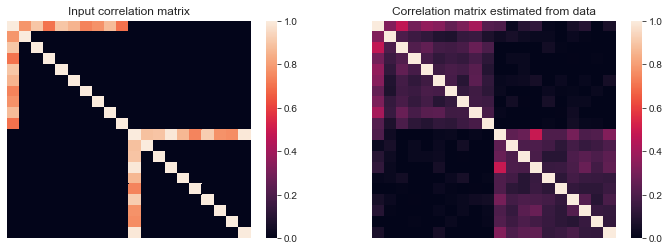

In [5]:
sigma_hat = np.cov(X, rowvar=False)
# bound sigma values between 0 and 1 
# (high variance/diagonal values might skew plot)
sigma_hat[sigma_hat > 1] = 1
sigma_hat[sigma_hat < 0] = 0

sns.set({'figure.figsize': (12, 4)})
fig, axarr = plt.subplots(1, 2)

sns.heatmap(sigma, ax=axarr[0])
axarr[0].get_xaxis().set_visible(False)
axarr[0].get_yaxis().set_visible(False)
axarr[0].set_title('Input correlation matrix')
sns.heatmap(sigma_hat, ax=axarr[1])
axarr[1].get_xaxis().set_visible(False)
axarr[1].get_yaxis().set_visible(False)
axarr[1].set_title('Correlation matrix estimated from data')

In [8]:
pcorrs = graph_to_pcorr(A, pos_lims=(0.7, 1), neg_lims=None)
theta = pcorr_to_prec(pcorrs)
print(theta[:5, :5])
print(np.linalg.cond(theta))

[[2.74664638 0.72340775 0.99231562 0.9296766  0.90841633]
 [0.72340775 2.74664638 0.         0.         0.        ]
 [0.99231562 0.         2.74664638 0.         0.        ]
 [0.9296766  0.         0.         2.74664638 0.        ]
 [0.90841633 0.         0.         0.         2.74664638]]
49.99847497994236


In [9]:
sigma = prec_to_cov(theta)
print(sigma[:5, :5])

[[ 4.73472631 -1.24702537 -1.71057436 -1.60259591 -1.56594701]
 [-1.24702537  0.6925201   0.4505286   0.42208939  0.41243686]
 [-1.71057436  0.4505286   0.98208116  0.57899006  0.56574945]
 [-1.60259591  0.42208939  0.57899006  0.9065222   0.53003703]
 [-1.56594701  0.41243686  0.56574945  0.53003703  0.88199626]]


Text(0.5, 1, 'Partial correlations estimated from data')

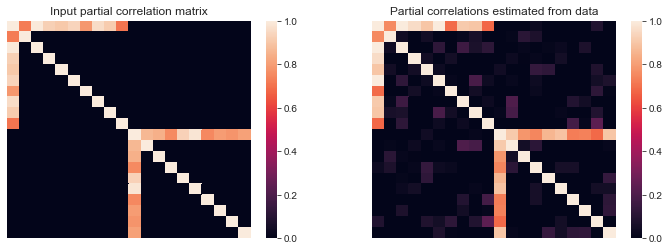

In [13]:
n = 1000
p = A.shape[0]

# TODO: how is check_valid handled when ignored?
X = np.random.multivariate_normal(mean=np.zeros(p),
                                  cov=sigma,
                                  size=(n,),
                                  check_valid='warn')
sigma_hat = np.cov(X, rowvar=False)
theta_hat = np.linalg.inv(sigma_hat)
# bound theta values between 0 and 1 
# (high variance/diagonal values might skew plot)
theta[theta > 1] = 1
theta[theta < 0] = 0
theta_hat[theta_hat > 1] = 1
theta_hat[theta_hat < 0] = 0

sns.set({'figure.figsize': (12, 4)})
fig, axarr = plt.subplots(1, 2)

sns.heatmap(theta, ax=axarr[0])
axarr[0].get_xaxis().set_visible(False)
axarr[0].get_yaxis().set_visible(False)
axarr[0].set_title('Input partial correlation matrix')
sns.heatmap(theta_hat, ax=axarr[1])
axarr[1].get_xaxis().set_visible(False)
axarr[1].get_yaxis().set_visible(False)
axarr[1].set_title('Partial correlations estimated from data')